In [1]:
"""
# https://www.kaggle.com/c/state-farm-distracted-driver-detection/data
# download data and then create validation from train

import os
import random

path = 'data/distracted_driver/imgs/'

if not os.path.isdir(path + 'val'): # make validation folder
    print('Making new directory: {}'.format(path + 'val'))
    os.mkdir(path + 'val')


# assumes there's a folder called 'train' which has all the labeled dataset
for driver_class in os.listdir(path + 'train/'): # move 20% of train to validation
    images = os.listdir(path + 'train/' + driver_class)
    val_list = random.sample(images, len(images) // 5)
    
    if not os.path.isdir(path + 'val/' + driver_class):
        print('Making new directory: {}'.format(path + 'val/' + driver_class))
        os.mkdir(path + 'val/' + driver_class)
    for image in val_list:
        os.rename(path + 'train/' + driver_class + '/' + image, path + 'val/' + driver_class + '/' + image)

# assumes there's a folder called test and will put all unlabeled dataset in test/unlabeled
if not os.path.isdir(path + 'test/unlabeled'): # moving test set into a folder of its own
    os.rename(path + 'test/', path + 'unlabeled/')
    os.mkdir(path + 'test/')
    os.rename(path + 'unlabeled/', path + 'test/unlabeled/')
""";

Making new directory: data/distracted_driver/imgs/val
Making new directory: data/distracted_driver/imgs/val/c7
Making new directory: data/distracted_driver/imgs/val/c8
Making new directory: data/distracted_driver/imgs/val/c6
Making new directory: data/distracted_driver/imgs/val/c0
Making new directory: data/distracted_driver/imgs/val/c2
Making new directory: data/distracted_driver/imgs/val/c4
Making new directory: data/distracted_driver/imgs/val/c9
Making new directory: data/distracted_driver/imgs/val/c1
Making new directory: data/distracted_driver/imgs/val/c3
Making new directory: data/distracted_driver/imgs/val/c5


In [1]:
from vgg16 import Vgg16
import os

path = 'data/distracted_driver/imgs/' # change for respective data set
model_path = 'data/distracted_driver/models/' # change for respective data set
batch_size = 64

if not os.path.isdir(model_path): # make validation folder
    print('Making new directory: {}'.format(model_path))
    os.mkdir(model_path)

vgg = Vgg16() # imagenet weights already loaded
# during training, shuffle should be set to true. Or else, it will likely receive training on the same class consecutively
train_batches = vgg.get_batches(path + 'train/', batch_size=batch_size, shuffle=True)
val_batches = vgg.get_batches(path + 'val/', batch_size=batch_size * 2, shuffle=False)
vgg.finetune(train_batches) # optimizer is Adam

Using Theano backend.
WARNING (theano.sandbox.cuda): CUDA is installed, but device gpu is not available  (error: Unable to get the number of gpus available: no CUDA-capable device is detected)


Found 17943 images belonging to 10 classes.
Found 4481 images belonging to 10 classes.


In [2]:
%%time
try:
    vgg.model.load_weights(model_path + 'complete_model_weights.h5')
    # print(vgg.model.evaluate_generator(val_batches, val_batches.nb_sample))
except IOError:
    vgg.fit(train_batches, val_batches, nb_epoch=1)  # also can use val as train set for faster training, shuffle=True
    vgg.model.save_weights(model_path + 'complete_model_weights.h5')

CPU times: user 224 ms, sys: 344 ms, total: 568 ms
Wall time: 4.91 s


In [3]:
%%time

import bcolz
from keras.layers.core import Dense, Dropout
from keras.models import Sequential


def save_array(fname, arr): 
    c = bcolz.carray(arr, rootdir=fname, mode='w')
    c.flush()
    
def load_array(fname): 
    return bcolz.open(fname)[:]

def split_model(model, layer_type=None):
    """
    Split model at first instance of layer_type.
    Note: could not perform deepcopy of model
    """
    if layer_type is None:
        layer_type = Dense
    first_dense_idx = [index for index, layer in enumerate(model.layers) if 
                       type(layer) is layer_type][0]    
    return model.layers[:first_dense_idx], model.layers[first_dense_idx:]

conv_layers, dense_layers = split_model(vgg.model)
conv_model = Sequential(conv_layers)
# have to turn shuffle off to computing features; once shuffled, cannot undo it
train_batches = vgg.get_batches(path + 'train/', batch_size=batch_size, shuffle=False)
val_batches.reset()
# have to re-instantiate val_batches because once used, the order will be offset

# this is possible since these features are much smaller than 
# raw images and are capable of being loaded into memory
try: 
    train_features = load_array(model_path + 'train_conv_features.bc/')
    val_features = load_array(model_path + 'val_conv_features.bc/')
except IOError:
    train_features = conv_model.predict_generator(
        train_batches, val_samples=train_batches.nb_sample)
    val_features = conv_model.predict_generator(
        val_batches, val_samples=val_batches.nb_sample)

    save_array(model_path + 'train_conv_features.bc/', train_features)
    save_array(model_path + 'val_conv_features.bc/', val_features)
    
print(train_features.shape, val_features.shape)

Found 17943 images belonging to 10 classes.
((17943, 25088), (4481, 25088))
CPU times: user 5.31 s, sys: 1.51 s, total: 6.82 s
Wall time: 11.3 s


In [9]:
for layer in vgg.model.layers:
    print layer, layer.input_shape

<keras.layers.core.Lambda object at 0x7f2be03ff210> (None, 3, 224, 224)
<keras.layers.convolutional.ZeroPadding2D object at 0x7f2bb46ed690> (None, 3, 224, 224)
<keras.layers.convolutional.Convolution2D object at 0x7f2bb46b9410> (None, 3, 226, 226)
<keras.layers.convolutional.ZeroPadding2D object at 0x7f2bb438f850> (None, 64, 224, 224)
<keras.layers.convolutional.Convolution2D object at 0x7f2bb439de50> (None, 64, 226, 226)
<keras.layers.pooling.MaxPooling2D object at 0x7f2bb46ed650> (None, 64, 224, 224)
<keras.layers.convolutional.ZeroPadding2D object at 0x7f2bb435e890> (None, 64, 112, 112)
<keras.layers.convolutional.Convolution2D object at 0x7f2bb42f1c50> (None, 64, 114, 114)
<keras.layers.convolutional.ZeroPadding2D object at 0x7f2bb430f090> (None, 128, 112, 112)
<keras.layers.convolutional.Convolution2D object at 0x7f2bb43220d0> (None, 128, 114, 114)
<keras.layers.pooling.MaxPooling2D object at 0x7f2bb435e850> (None, 128, 112, 112)
<keras.layers.convolutional.ZeroPadding2D object at

In [6]:
for layer in 
conv_model.layers[1].input_shape

(None, 3, 224, 224)

In [4]:
# cannot modify layers after they have been created

from keras.optimizers import Adam
import numpy as np
from sklearn.preprocessing import OneHotEncoder

def get_fc_model_2(dense_layers, opt=None, new_dropout_p=None):
    
    def proc_wgts(layer): # don't know how to reflate the weights if given
        # different p for different layers
        return [o / 2 for o in layer.get_weights()]
    
    def make_new_layer(layer, new_dropout_p):
        if type(layer) is Dense:
            return Dense(output_dim=layer.output_dim, input_shape=
                         layer.input_shape[1:], activation=layer.activation)
        # notice the input_shape is a slice, also takes care of number of 
        # output nodes and softmax
        elif type(layer) is Dropout:
            return Dropout(p=new_dropout_p, input_shape=layer.input_shape[1:])
        else:
            raise Exception('Unexpected layer')
    
    if new_dropout_p is None:
        new_dropout_p = 0.0
    model = Sequential([make_new_layer(layer, new_dropout_p) 
                        for layer in dense_layers])

    for l1,l2 in zip(model.layers, dense_layers): 
        l1.set_weights(proc_wgts(l2))
        
    if opt is None:
        opt = Adam(lr=0.00001) # need small learning rate or else 
        # loss will increase and accuracy will decrease
    model.compile(optimizer=opt, loss='categorical_crossentropy', 
                  metrics=['accuracy'])
    return model

def onehot(x): 
    return np.array(OneHotEncoder().fit_transform(x.reshape(-1, 1)).todense())


train_labels = onehot(train_batches.classes)
val_labels = onehot(val_batches.classes)

dense_model = get_fc_model_2(dense_layers)
#print(dense_model.evaluate(train_features, train_labels))
print(dense_model.evaluate(val_features, val_labels))
# it appears that splitting the model up and evaluate will give slightly different results than
# original VGG model

4480/4481 [============================>.] - ETA: 0s[1.7123786271669268, 0.85896005355947336]


In [5]:
try:
    dense_model.load_weights(model_path + 'no_dropout.h5')
    print(dense_model.evaluate(val_features, val_labels))
except IOError:

    dense_model.fit(train_features, train_labels, nb_epoch=2, 
        batch_size=batch_size, validation_data=(val_features, val_labels))
    # appears without loading weights from 1 epoch of training, 
    # training with small learning rate still works well
    dense_model.save_weights(model_path + 'no_dropout.h5')

4480/4481 [============================>.] - ETA: 0s[0.011172914775693238, 0.9966525329167597]


In [106]:
dense_model.fit(train_features, train_labels, nb_epoch=2, 
    batch_size=batch_size, validation_data=(val_features, val_labels))

Train on 17943 samples, validate on 4481 samples
Epoch 1/2
17943/17943 [==============================] - 28s - loss: 0.0091 - acc: 0.9974 - val_loss: 0.0151 - val_acc: 0.9964
Epoch 2/2
17943/17943 [==============================] - 28s - loss: 0.0050 - acc: 0.9985 - val_loss: 0.0186 - val_acc: 0.9951


4480/4481 [============================>.] - ETA: 0s[[496   0   0   0   0   0   1   0   0   0]
 [  0 453   0   0   0   0   0   0   0   0]
 [  0   0 463   0   0   0   0   0   0   0]
 [  0   0   0 469   0   0   0   0   0   0]
 [  0   0   0   0 465   0   0   0   0   0]
 [  1   0   0   0   0 460   1   0   0   0]
 [  0   0   0   0   0   0 465   0   0   0]
 [  0   0   0   0   0   0   0 400   0   0]
 [  0   0   0   0   1   0   0   1 375   5]
 [  1   1   0   0   0   0   1   0   2 420]]


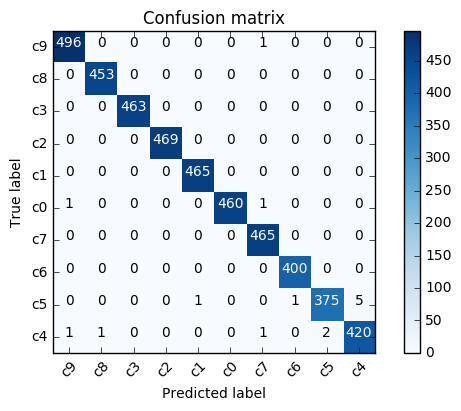

In [7]:
from matplotlib import pyplot as plt
%matplotlib inline
from sklearn.metrics import confusion_matrix
from utils import plot_confusion_matrix

val_predictions = dense_model.predict_classes(val_features)
cm = confusion_matrix(val_batches.classes, val_predictions)
plot_confusion_matrix(cm, val_batches.class_indices);

In [107]:
%%time 
full_model = Sequential(conv_layers)
full_model.add(dense_model)
full_model.compile(Adam(lr=0.00001), loss='categorical_crossentropy', 
                  metrics=['accuracy'])

print(full_model.evaluate_generator(val_batches, val_batches.N))

[0.018636761547046111, 0.99509038161124752]
CPU times: user 2min 40s, sys: 24.6 s, total: 3min 5s
Wall time: 1min 53s


In [108]:
%%time
# submission
test_batches = vgg.get_batches(path + 'test/', batch_size=batch_size * 2, 
                               shuffle=False)
test_predictions = full_model.predict_generator(test_batches, test_batches.N)

Found 79726 images belonging to 1 classes.
CPU times: user 43min 1s, sys: 7min 20s, total: 50min 21s
Wall time: 32min 21s


In [109]:
import pandas as pd
from IPython.display import FileLink

submission_name = 'submission_3.csv'
df_filesnames = pd.DataFrame({'img': [name.split('/')[1] 
    for name in test_batches.filenames]}) # have to give correct column name

df_predictions = pd.DataFrame(test_predictions, columns=vgg.classes)
pd.concat([df_filesnames, df_predictions], axis=1).to_csv(
    path + submission_name, index=False)

FileLink(path + submission_name)

/home/ubuntu/courses/deeplearning1/nbs/data/distracted_driver/imgs/submission_3.csv

In [11]:
%%time
# pre-calculating convolutional features on test dataset
test_batches = vgg.get_batches(path + 'test/', batch_size=batch_size * 2, 
                               shuffle=False)
test_features = conv_model.predict_generator(
    test_batches, val_samples=test_batches.nb_sample)
save_array(model_path + 'test_conv_features.bc/', test_features)

Found 79726 images belonging to 1 classes.
CPU times: user 44min 16s, sys: 7min 49s, total: 52min 6s
Wall time: 32min 38s


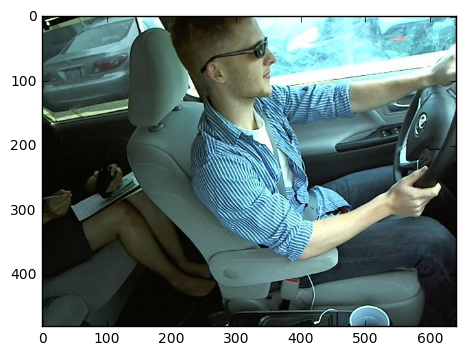

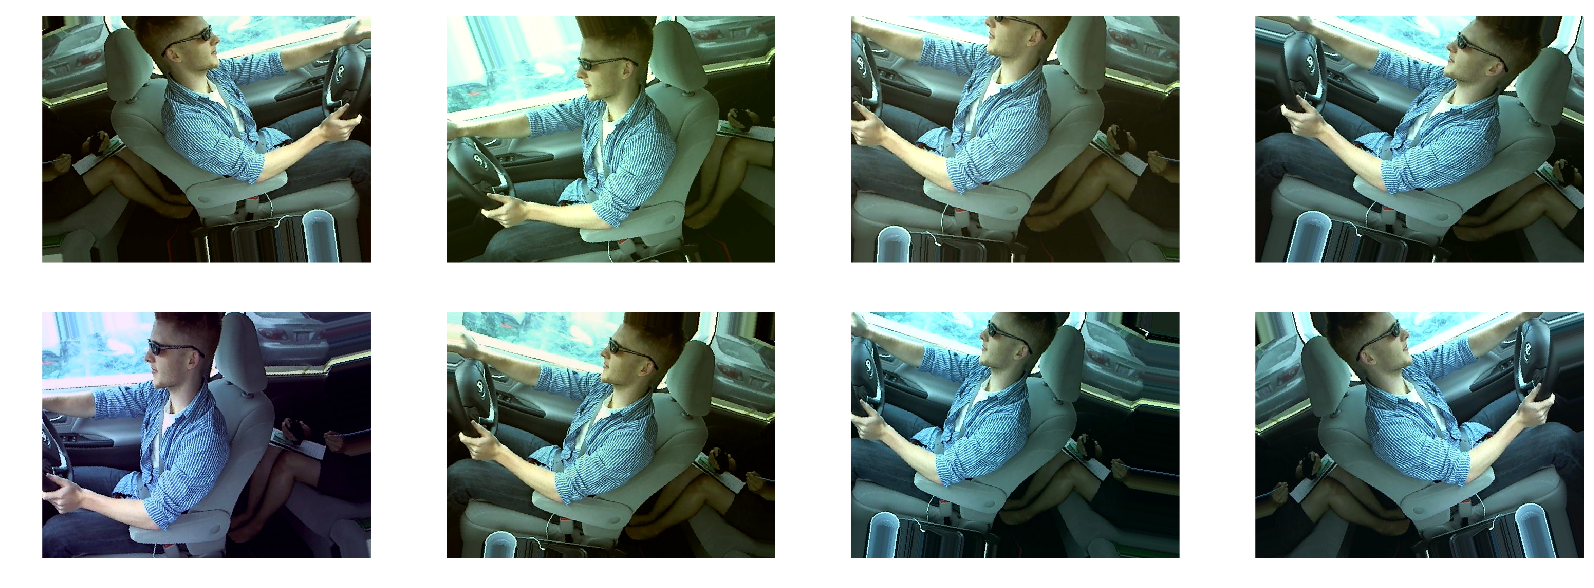

In [87]:
# Data Augmentation
from keras.preprocessing import image
from scipy import ndimage
from utils import plots

img_gen = image.ImageDataGenerator(
    rotation_range=20, width_shift_range=0.1, height_shift_range=0.1, 
    shear_range=0.05, zoom_range=0.1, horizontal_flip=True, 
    channel_shift_range=20, dim_ordering='tf')

img = np.expand_dims(ndimage.imread(path + 'train/c0/img_100026.jpg'), 0)
aug_iter = img_gen.flow(img) # Request the generator to create batches from this image
aug_imgs = [next(aug_iter)[0].astype(np.uint8) for i in range(8)]

plt.imshow(img[0])
plots(aug_imgs, (20,7), 2)

# Deprecated
Unless image augmentation, pre-calculating image features through conv-layers will speed up training in dense layers.  

In [ ]:
### predict_generator is faster than manual because it has queue for loading images, though sometimes gives memory error
### try not to run any other scripts while this is performing

"""
%%time
# manual training model is more robost than generator due to intermediate weight saves 
# 6:52
from tqdm import tqdm
import psutil; import os

test_batches = vgg.get_batches(path + 'test/', batch_size=batch_size * 2, shuffle=False)

images = []
for i in tqdm(range(int(np.ceil(test_batches.N / float(test_batches.batch_size))))):
    minibatch = next(test_batches)[0]
    images.append(vgg.model.predict_on_batch(minibatch))
#    print(psutil.Process(os.getpid()).memory_info().rss / 1e9)

temp = np.concatenate(images)
""";

In [82]:
from IPython.display import FileLink

predictions = pd.DataFrame(temp, columns=vgg.classes)
#pd.read_csv('temp.csv', names=sorted(val_batches.class_indices, key=val_batches.class_indices.get))
pd.concat([df_filesnames, predictions], axis=1).to_csv(path + 'submission_2.csv', index=False)

FileLink(path + 'submission_2.csv')

/home/ubuntu/courses/deeplearning1/nbs/data/distracted_driver/imgs/submission_2.csv

In [152]:
def shuffler(feature_data, labels):
    assert feature_data.shape[0] == labels.shape[0], "Shapes are not matching"
    new_order = np.random.permutation(len(feature_data))
    return feature_data[new_order], labels[new_order]

train_features2, train_labels2 = shuffler(train_features, train_labels)

In [34]:
def get_data(path): # actually pretty fast
    batches = vgg.get_batches(path, shuffle=False, batch_size=1)
    return np.concatenate([batches.next()[0] for i in range(batches.nb_sample)])

# val_features2 = get_data(path + 'val/')

In [89]:
%%time

def reinsert_weights(vgg_model, tuned_dense_model):
    """
    For each layer in the tuned_dense_model, reinsert those weights
    back into the VGG model
    """
    dense_model_length = len(tuned_dense_model.layers)
    assert all(
        type(l1) == type(l2) for l1, l2 in zip(
        vgg_model.layers[-dense_model_length:], 
        tuned_dense_model.layers)), "Model layers do not match"
    for l1, l2 in zip(vgg_model.layers[-dense_model_length:], 
                      tuned_dense_model.layers):
        l1.set_weights(l2.get_weights())

reinsert_weights(vgg.model, dense_model)
print(vgg.model.evaluate_generator(val_batches, val_batches.nb_sample))

[0.011172915000366237, 0.9966525329167597]
CPU times: user 2min 49s, sys: 25.5 s, total: 3min 14s
Wall time: 1min 51s


In [105]:
from sklearn.metrics import log_loss
import numpy as np
from keras.metrics import categorical_crossentropy, categorical_accuracy

val_scores = dense_model.predict_on_batch(val_features)
print(log_loss(val_labels, val_scores))
print(log_loss(val_labels, np.clip(val_scores, 0.025, 0.975)))
print(log_loss(val_labels, np.clip(val_scores, 0.05, 0.95)))

print()

print(categorical_crossentropy(val_labels, val_scores).eval())
print(categorical_accuracy(val_labels, val_scores)).eval()

0.0111729129108
0.215507786413
0.394589636979
()
0.0111729136316
0.996652543545


In [ ]:
# check most right, wrong, ambivalent
# train more dense layers

# how to pre-compute, can run through images with augmentation, store to numpy file,
# which is read. Numpy file can be deleted. Generator is slower

## error: accuracy is low, essentially random. features are not shuffled, labels are shuffled, learning rate too high